## Sample Analysis for Tracker Observables

Begin by importing the allmighty `numpy` and `pyplot`

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as img
import random 

from os import listdir
import re

# Weight Events

Small bit of code which weights the simulated muon neutrinos according to the expected number of events at FaserNu

In [2]:
def weight_muon_neutrinos(data):
    
    # Import data for the number of expected muon neutrino interactions during run 3
    expectedData1 = np.loadtxt('FluenceFiles/FASER_-14.txt')
    expectedData2 = np.loadtxt('FluenceFiles/FASER_14.txt')
    
    expEnergy = expectedData1[:,0]
    expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1
    
    # Setup variables for weighting neutrino events.
    volFlu  = 25 * 25 * 100  # Volume of tungsten target used for FASER_-14.txt file
    rhoTung = 19.3           # Density of tungsten
    volTung = 25 * 30 * 106  # Volume of tungsten target used in FLUKA simulation
    rhoLead = 11.35          # Density of lead
    volLead = 30 * 40 * 10   # Volume of lead shielding used in FLUKA simulation
    
    # Weight by the masses of the targets
    tungWeight = (volTung/volFlu)
    leadWeight = volLead/volFlu * rhoLead/rhoTung
    
    # Weight per primary
    numSimTung = 13 * 1000
    numSimLead = 5 * 1000
    
    # Simulation energies are close to those in FASER_-14.txt
    # Use a small buffer to ensure there is a match
    eps  = 0.01 # Within 10 MeV
    for event in data:
        energy = event['primaryEnergy']
        zpos   = event['zposition']

        mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
        numExp = expTotal[mask]
        if zpos < 120: # If interacted in tungsten
            weight = tungWeight * numExp / numSimTung
        else:
            weight = leadWeight * numExp / numSimLead

        event['weight'] = weight[0] # Method with the mask returns a numpy array with one-element

def weight_elec_neutrinos(data):
    
    # Import data for the number of expected muon neutrino interactions during run 3
    expectedData1 = np.loadtxt('FluenceFiles/FASER_-12.txt')
    expectedData2 = np.loadtxt('FluenceFiles/FASER_12.txt')
    
    expEnergy = expectedData1[:,0]
    expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1
    
    # Setup variables for weighting neutrino events.
    volFlu  = 25 * 25 * 100  # Volume of tungsten target used for FASER_-14.txt file
    rhoTung = 19.3           # Density of tungsten
    volTung = 25 * 30 * 106  # Volume of tungsten target used in FLUKA simulation
    rhoLead = 11.35          # Density of lead
    volLead = 30 * 40 * 10   # Volume of lead shielding used in FLUKA simulation
    
    # Weight by the masses of the targets
    tungWeight = (volTung/volFlu)
    leadWeight = volLead/volFlu * rhoLead/rhoTung
    
    # Weight per primary
    numSimTung = 13 * 300
    numSimLead = 5 * 300
    
    # Simulation energies are close to those in FASER_-14.txt
    # Use a small buffer to ensure there is a match
    eps  = 0.01 # Within 10 MeV
    for event in data:
        energy = event['primaryEnergy']
        zpos   = event['zposition']

        mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
        numExp = expTotal[mask]
        if zpos < 120: # If interacted in tungsten
            weight = tungWeight * numExp / numSimTung
        else:
            weight = leadWeight * numExp / numSimLead

        event['weight'] = weight[0] # Method with the mask returns a numpy array with one-element

def weight_muons(files):
    
    data = np.array([])
    
    # Load fluence files for muons and anti-muons and combine them
    expectedData1 = np.loadtxt('FluenceFiles/negative_muon_flux.csv')
    expectedData2 = np.loadtxt('FluenceFiles/positive_muon_flux.csv')
    
    expEnergy = expectedData1[:,0]
    expFlu    = expectedData1[:,1] + expectedData2[:,1]
    
    # expFlu has units of GeV^-1 cm^-2 s^-1
    # Multiply by primary energy to change to cm^-2 s^-1
    expFlu = expFlu * expEnergy
    
    LHCflu = 2 * (10 ** -5) # fb^-1 s^-1 from LHC
    expFlu = expFlu / LHCflu # fb (at the LHC) * cm^-2 (per unit area at FASER)
    
    A_lr = 6.5 * 35 # left/right simulation area in cm^2
    A_tb = 43  * 4 # top/bot simulation area in cm^2
    
    expTot_lr = expFlu * A_lr
    expTot_tb = expFlu * A_tb
    
    # Number simulated in each region for each input file
    simTot = countSimTotals(files)
    
    # Controls accepted range for matching primary energy - Anything below ~200 GeV should be identical
    eps  = 0.01 # Within 10 MeV
    
    for file in files:
        tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
        side = re.match(r'.*_([a-z]*)[0-9][0-9][0-9].npy', file)[1]
        if (side == 'left') or (side == 'right'):
            expTot = expTot_lr
        elif (side == 'top') or (side == 'bot'):
            expTot = expTot_tb
        
        # Add the appropriate weight to each event
        for event in tmp:
            energy = event['primaryEnergy']
            simTotCur = simTot[side][energy]
            
            # Find which energy this primary falls into
            mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
            # Number of expected muons at this energy
            numExp = expTot[mask]
            # weight = number expected / number simulated
            event['weight'] = numExp[0] / simTotCur # Weight for 1 fb^-1 run at the LHC
        
        data = np.append(data,tmp)
    
    return data

def countSimTotals(files):
    
    simTot = {}
    for side in ['left', 'right', 'top', 'bot']:
        sideDict = {}
        sideFiles = [file for file in files if re.search(f'.*{side}.*', file)]
        for file in sideFiles:
            energy = np.load('NumpyArrays/' + file, allow_pickle=True)[0]['primaryEnergy']
            if not(energy in sideDict.keys()):
                sideDict[energy] = 21527
            else:
                sideDict[energy] += 21527
        simTot[side] = sideDict
            
    return simTot

The following block of code runs the weighting function on the muon neutrino data and muon data in the `NumpyArrays` directory.

In [3]:
%%time
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'muon_neutrinos',file)]
muon_neutrino_data = np.array([])
for file in files:
    tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
    weight_muon_neutrinos(tmp)
    np.save('NumpyArrays/' + file, tmp)
    
    muon_neutrino_data = np.append(muon_neutrino_data, tmp)

CPU times: user 5.46 s, sys: 186 ms, total: 5.64 s
Wall time: 5.65 s


In [4]:
%%time
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'elec_neutrinos',file)]
elec_neutrino_data = np.array([])
for file in files:
    tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
    weight_elec_neutrinos(tmp)
    np.save('NumpyArrays/' + file, tmp)
    
    elec_neutrino_data = np.append(elec_neutrino_data, tmp)

CPU times: user 2.24 s, sys: 128 ms, total: 2.37 s
Wall time: 2.37 s


In [5]:
%%time
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'muons',file)]
muon_data = weight_muons(files)

CPU times: user 1min 10s, sys: 5.82 s, total: 1min 16s
Wall time: 1min 16s


In [6]:
%%time
objects = []
for event in muon_data:
    tmp = {'energy': event['primaryEnergy'],
           'weight': event['weight']}
    if not(tmp in objects):
        objects.append(tmp)  
sorted(objects, key=lambda d: d['energy']) 

CPU times: user 1.91 s, sys: 4.11 ms, total: 1.92 s
Wall time: 1.92 s


[{'energy': 121.119, 'weight': 4.9678182993412925},
 {'energy': 121.119, 'weight': 5.713744505056339},
 {'energy': 327.154, 'weight': 3.600687797147162},
 {'energy': 327.154, 'weight': 3.130619983629489},
 {'energy': 524.136, 'weight': 1.8679824616557807},
 {'energy': 524.136, 'weight': 2.0589438470285377},
 {'energy': 721.13, 'weight': 0.9487803641692139},
 {'energy': 721.13, 'weight': 1.04577293046752},
 {'energy': 924.133, 'weight': 1.0723325091578204},
 {'energy': 924.133, 'weight': 1.1819556484176557},
 {'energy': 1124.14, 'weight': 1.823617472459005},
 {'energy': 1124.14, 'weight': 1.6220411390456309},
 {'energy': 1324.14, 'weight': 2.022693058539345},
 {'energy': 1324.14, 'weight': 2.2740597104363127},
 {'energy': 1524.14, 'weight': 1.9096416384039232},
 {'energy': 1524.14, 'weight': 1.6985564928531338},
 {'energy': 1724.13, 'weight': 1.3096213802724486},
 {'energy': 1724.13, 'weight': 1.1648603873657977},
 {'energy': 1924.14, 'weight': 0.9011713198268455},
 {'energy': 1924.14, 

In [7]:
A_lr = 6.5 * 35 # left/right simulation area in cm^2
A_tb = 43  * 4 # top/bot simulation area in cm^2

weights = {}
for obj in objects:
    energy = obj['energy']
    weight = obj['weight']
    if not(energy in weights.keys()):
        weights[energy] = weight
    else:
        if weight > weights[energy]:
            weight_lr = weight
            weight_tb = weights[energy]
        else:
            weight_lr = weights[energy]
            weight_tb = weight
        weights[energy] = (weight_lr * A_lr + weight_tb * A_tb)/(A_lr + A_tb)

### Display event

Here is some quick event display function I wrote based on Michael's code

In [8]:
def display_event(data, ievent=0):
    
    #load event
    event = data[ievent]
    if event['scintillator'][0]> 0: return 0
    if event['scintillator'][2]==0: return 0 
    
    # initialize
    multiplier=2
    matplotlib.rcParams.update({'font.size': 15*multiplier})
    matplotlib.rcParams['axes.linewidth'] = multiplier
    fig = plt.figure(figsize=(16*multiplier,7*multiplier))
    
    # Setup some nice axes 
    x0, x1 = 0.01, 0.94
    width = (x1-x0)/4
    h_tr, h_pic, h_sc = 0.55, 0.35, 0.08
    ax0 = fig.add_axes([x0          , 0.02+h_tr      , (x1-x0)   , h_pic])    
    ax1 = fig.add_axes([x0 + 0*width, 0.02           , width     , h_tr ])
    ax2 = fig.add_axes([x0 + 1*width, 0.02           , width     , h_tr ])
    ax3 = fig.add_axes([x0 + 2*width, 0.02           , width     , h_tr ])
    ax4 = fig.add_axes([x0 + 3*width, 0.02           , 1.25*width, h_tr ])
    ax5 = fig.add_axes([x0          , 0.02+h_tr+h_pic, 0.8       , 0.05  ])
    ax6 = fig.add_axes([x0+0.8      , 0.02+h_tr+h_pic, x1-x0-0.8 , 0.05  ])
    
    #plot image of detector
    image = img.imread('Fig_Layout.jpg')
    ax0.imshow(image)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.spines.clear()
    
    # Plot the tracker images
    bins = (np.linspace(-12.5, 12.5, 26),np.linspace(-12.5, 12.5, 26))
    for ax, layer in zip([ax1,ax2,ax3,ax4],['hits1','hits2','hits3','hits4']):
        image = np.array(event[layer])
        if len(image)==0: image = np.array([[0,0,0]])
        hist = ax.hist2d(image.T[0], image.T[1], weights=image.T[2], bins=bins, 
                  norm=matplotlib.colors.LogNorm(vmin=1,vmax=100),cmap='cool')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(hist[3], ax=ax4)
    
    # Plot scintillators
    ax5.hist2d(np.linspace(0.5,8.5,9), np.zeros(9) , weights=event['scintillator'][:-1], bins=(np.linspace(0,9,10),[-1,1]), 
                  norm=matplotlib.colors.LogNorm(vmin=0.1,vmax=1),cmap='rainbow')
    for x in np.linspace(0,8,9): 
        ax5.plot([x,x],[-1,1],lw=multiplier,c="k")
        ax5.text(x+0.06,-0.75,str(int(x+1)))
    ax5.set_xticks([])
    ax5.set_yticks([])
    
    # Plot calorimeter
    ax6.text(0.5,0.5,"E="+str(event['calorimeter'])+" GeV",ha="center", va="center")
    ax6.fill([0,1,1,0], [0,0,1,1], c="lightgreen")
    ax6.set_xlim(0,1)
    ax6.set_ylim(0,1)
    ax6.set_xticks([])
    ax6.set_yticks([])

    # Return figure so user can manipulate or save the plots
#     plt.savefig("EventDisplays/Event_"+str(ievent)+".pdf")
#     plt.show()
    
    return 1


In [9]:
# numevents = 0 
# while numevents < 1:
#     ievent = random.randrange(len(muon_neutrino_data))
#     numevents+=display_event(muon_neutrino_data, ievent=ievent)

In [10]:
# # Doing the same thing for muon data
# numevents = 0 
# while numevents < 1:
#     ievent = random.randrange(len(muon_data))
#     numevents+=display_event(muon_data, ievent=ievent)

# Scintillators and Calorimeter Energy

In [11]:
def emptyBarPlot(bins, counts):
    bins2 = np.append(bins,bins)
    bins2[0:len(bins2):2] = bins
    bins2[1:(len(bins2)-1):2] = bins[1:]

    counts2 = np.append(counts,counts)
    counts2[0:len(counts2):2] = counts
    counts2[1:len(counts2):2] = counts
    plt.plot(bins2, counts2)

In [12]:
def countSignalEvents(data, signal = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], entries = [n for n in range(10)],
                      minCal = 0, weighted = True):
    signal = np.array(signal)
    entries = np.array(entries)

    matches = [event for event in data
               if ((event['calorimeter'] > minCal) and (event['scintillator'][entries] == signal).all())]
    
    primEnergies = sorted(set([event['primaryEnergy'] for event in matches]))
    
    count = 0
    uncertainty = 0
    
    for en in primEnergies:
        weights = [event['weight'] for event in matches if event['primaryEnergy'] == en]
        for weight in set(weights):
            mask = weights == weight
            if weighted:
                count += np.sum(np.array(weights)[mask])
                uncertainty += np.sum(np.array(weights)[mask]) / np.sqrt(np.sum(mask))
            else:
                count += np.sum(mask)
                uncertainty += np.sqrt(np.sum(mask))

    return count, uncertainty

In [13]:
def binSignal(data, bins = None, signal = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], entries = [n for n in range(10)],
             weighted = True):
    signal = np.array(signal)
    entries = np.array(entries)

    matches = [event for event in data if (event['scintillator'][entries] == signal).all()]
    if bins is None:
        deposits = [event['calorimeter'] for event in matches]
        minDep = min(deposits) - 1
        maxDep = max(deposits) + 1
        low = np.log10(max(10**-2, minDep)) # Sets 0.01 as the smallest bin
        high = max(3, np.log10(maxDep)) # Sets 1000 as the largest bin
        bins = np.logspace(low, high, 100)
        
    primEnergies = sorted(set([event['primaryEnergy'] for event in matches]))

    binned = {'bins': bins}

    for energy in primEnergies:
        subdata = [(event['calorimeter'], event['weight']) for event in matches if event['primaryEnergy'] == energy]
        cals = [x[0] for x in subdata]
        weights = [x[1] for x in subdata]
        
        counts = np.zeros(np.size(bins))
        uncertainties = np.zeros(np.size(bins))
        for weight in set(weights):
            mask = weights == weight
            
            cal = np.array(cals)[mask]
            ids = np.searchsorted(bins,cal)
            
            count = np.zeros(np.size(bins))
            raw_count = np.zeros(np.size(bins))
            for id_ in ids:
                try:
                    raw_count[id_] += 1
                    count[id_] += weight
                except IndexError:
                    print(wid[0])
                    print(energy)
                    break
            if weighted:
                counts += count
                mask = raw_count > 0
                uncertainties[mask] += count[mask] / np.sqrt(raw_count[mask])
            else:
                counts += raw_count
                uncertainties += np.sqrt(raw_count)
                
        binned[energy] = (counts, uncertainties)
        
    return binned

In [14]:
def plotBinnedData(data, scale = 1, primaryEnergies = None):
    bins = data['bins']
    if primaryEnergies is None:
        primaryEnergies = [e for e in data.keys() if isinstance(e,float)]
    
    curCounts = np.zeros(np.size(bins))
    for energy in primaryEnergies:
        counts = data[energy][0]
        curCounts += counts * scale
        
        emptyBarPlot(bins,curCounts)
        
def plotCounts(data, scale = 1, primaryEnergies = None):
    bins = data['bins']
    if primaryEnergies is None:
        primaryEnergies = [e for e in data.keys() if isinstance(e,float)]
    
    totalCounts = 0
    for energy in primaryEnergies:
        counts = data[energy][0] * scale
        uncertainty = data[energy][1] * scale
        totalCounts += np.sum(counts)
        
        plt.plot(bins,counts, 'ko', markersize=4)
        plt.errorbar(bins,counts, uncertainty, fmt=' ', color='b')
    return totalCounts

def plotCountsSummed(data, scale = 1, primaryEnergies = None):
    bins = data['bins']
    if primaryEnergies is None:
        primaryEnergies = [e for e in data.keys() if isinstance(e,float)]
    
    totalCounts = 0
    totalUncertainty = 0
    for energy in primaryEnergies:
        counts = data[energy][0] * scale
        uncertainty = data[energy][1] * scale
        totalCounts += counts
        totalUncertainty += uncertainty
        
    plt.plot(bins,totalCounts, 'ko', markersize=4)
    plt.errorbar(bins,totalCounts, totalUncertainty, fmt=' ', color='b')
    return np.sum(totalCounts)

CPU times: user 6.64 s, sys: 411 µs, total: 6.65 s
Wall time: 6.65 s


Text(0, 0.5, 'Muon Expected Counts for 1 fb^-1')

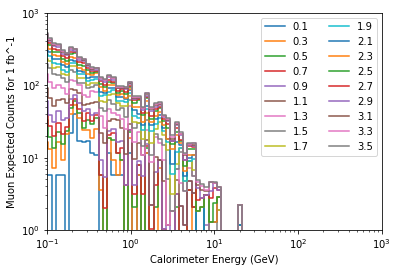

In [15]:
%%time
data1 = binSignal(muon_data)

plotBinnedData(data1)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 10**3])
plt.ylim([10**0, 10**3])
energies = [e for e in data1.keys() if isinstance(e,float)]
plt.legend([str(np.round(energy,-2)/1000) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Muon Expected Counts for 1 fb^-1');

CPU times: user 965 ms, sys: 0 ns, total: 965 ms
Wall time: 965 ms


Text(0, 0.5, 'Muon Neutrino Expected Counts for 1 fb^-1')

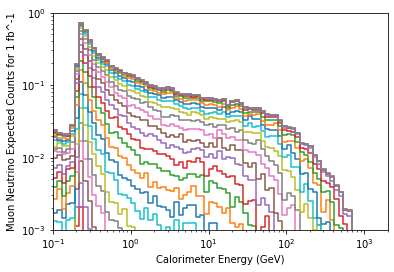

In [16]:
%%time
data2 = binSignal(muon_neutrino_data)

plotBinnedData(data2)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 2*10**3])
plt.ylim([10**-3, 10**0])
energies = [e for e in data2.keys() if isinstance(e,float)]
# plt.legend([str(int(np.round(energy))) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Muon Neutrino Expected Counts for 1 fb^-1');

CPU times: user 172 ms, sys: 12 µs, total: 172 ms
Wall time: 171 ms


Text(0, 0.5, 'Electron Neutrino Expected Counts for 1 fb^-1')

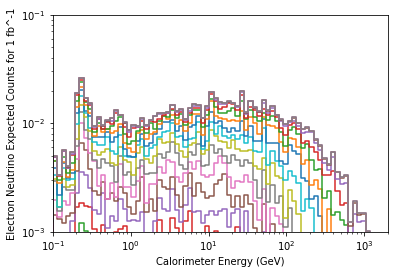

In [17]:
%%time
data3 = binSignal(elec_neutrino_data)

plotBinnedData(data3)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 2*10**3])
plt.ylim([10**-3, 10**-1])
energies = [e for e in data3.keys() if isinstance(e,float)]
# plt.legend([str(int(np.round(energy))) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Electron Neutrino Expected Counts for 1 fb^-1');

In [18]:
def printCounts(minCal, scale):
    
    muons = countSignalEvents(muon_data, minCal = minCal)
    muonCount = muons[0]*scale
    muonErr   = muons[1]*scale
    numus = countSignalEvents(muon_neutrino_data, minCal = minCal)
    numuCount = numus[0]*scale
    numuErr   = numus[1]*scale
    nues   = countSignalEvents(elec_neutrino_data, minCal = minCal)*scale
    nueCount  = nues[0]*scale
    nueErr    = nues[1]*scale
    print(f'For {scale} fb^-1 and a calorimeter cut = {minCal} GeV:',
          '\n\tMuon: \t\t\t', np.round(muonCount,2), '+/-', np.round(muonErr,2),
          '\n\tMuon Neutrino: \t\t', np.round(numuCount,2), '+/-', np.round(numuErr,2),
          '\n\tElectron Neutrino: \t', np.round(nueCount,2), '+/-', np.round(nueErr,2))
    
LHCrun = 5 # in fb^-1
for minCal in [0, 1, 5, 10, 15, 20, 25, 30, 35]:
    printCounts(minCal = minCal, scale = LHCrun)
    

For 5 fb^-1 and a calorimeter cut = 0 GeV: 
	Muon: 			 289277.31 +/- 7440.66 
	Muon Neutrino: 		 37.84 +/- 0.95 
	Electron Neutrino: 	 4.73 +/- 0.33
For 5 fb^-1 and a calorimeter cut = 1 GeV: 
	Muon: 			 3060.22 +/- 685.48 
	Muon Neutrino: 		 12.89 +/- 0.54 
	Electron Neutrino: 	 2.92 +/- 0.26
For 5 fb^-1 and a calorimeter cut = 5 GeV: 
	Muon: 			 175.61 +/- 107.82 
	Muon Neutrino: 		 6.97 +/- 0.39 
	Electron Neutrino: 	 2.17 +/- 0.22
For 5 fb^-1 and a calorimeter cut = 10 GeV: 
	Muon: 			 27.19 +/- 27.19 
	Muon Neutrino: 		 5.08 +/- 0.33 
	Electron Neutrino: 	 1.78 +/- 0.2
For 5 fb^-1 and a calorimeter cut = 15 GeV: 
	Muon: 			 11.05 +/- 11.05 
	Muon Neutrino: 		 4.07 +/- 0.29 
	Electron Neutrino: 	 1.52 +/- 0.18
For 5 fb^-1 and a calorimeter cut = 20 GeV: 
	Muon: 			 0 +/- 0 
	Muon Neutrino: 		 3.42 +/- 0.26 
	Electron Neutrino: 	 1.35 +/- 0.17
For 5 fb^-1 and a calorimeter cut = 25 GeV: 
	Muon: 			 0 +/- 0 
	Muon Neutrino: 		 2.91 +/- 0.23 
	Electron Neutrino: 	 1.2 +/- 0.15
For 5 f

# Estimating rates for high energy deposits

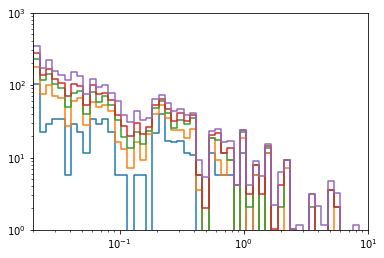

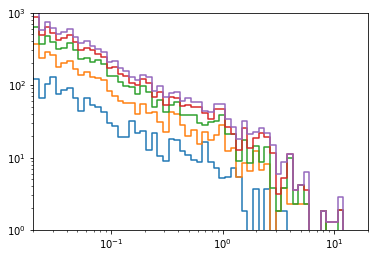

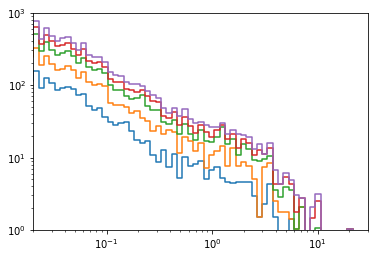

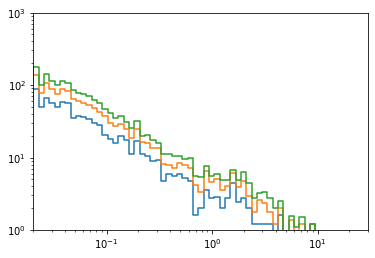

In [19]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_data])))

mask = (primEnergies > 0) & (primEnergies < 1000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 10**1])
plt.ylim([10**0, 10**3]);

plt.figure();
mask = (primEnergies > 1000) & (primEnergies < 2000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 2*10**1])
plt.ylim([10**0, 10**3]);

plt.figure();
mask = (primEnergies > 2000) & (primEnergies < 3000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 3*10**1])
plt.ylim([10**0, 10**3]);

plt.figure();
mask = (primEnergies > 3000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 3*10**1])
plt.ylim([10**0, 10**3]);

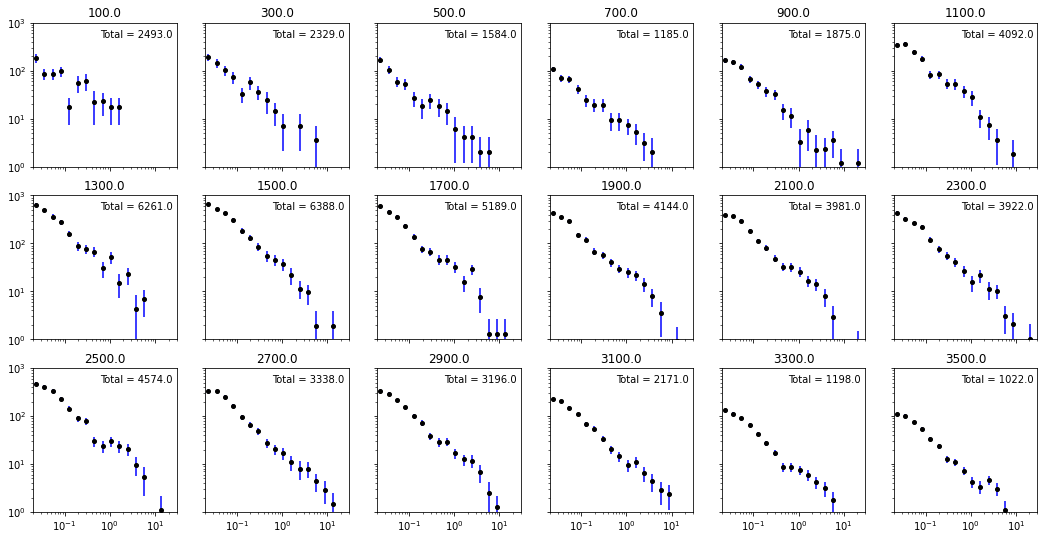

In [20]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_data])))
data1 = binSignal(muon_data, bins=np.logspace(-2,1.5,20), weighted=True)

fig, axs = plt.subplots(3,6, sharex=True, sharey=True,  figsize=(18,9))
axs = [axs[i,j] for i in range(3) for j in range(6)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data1, primaryEnergies = [primEnergy])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([2*10**-2, 3*10**1])
    plt.ylim([10**0, 1000]);
    plt.title(str(np.round(primEnergy,-2)))
    plt.text(6*10**-1, 5*10**2,'Total = ' + str(np.round(counts)))

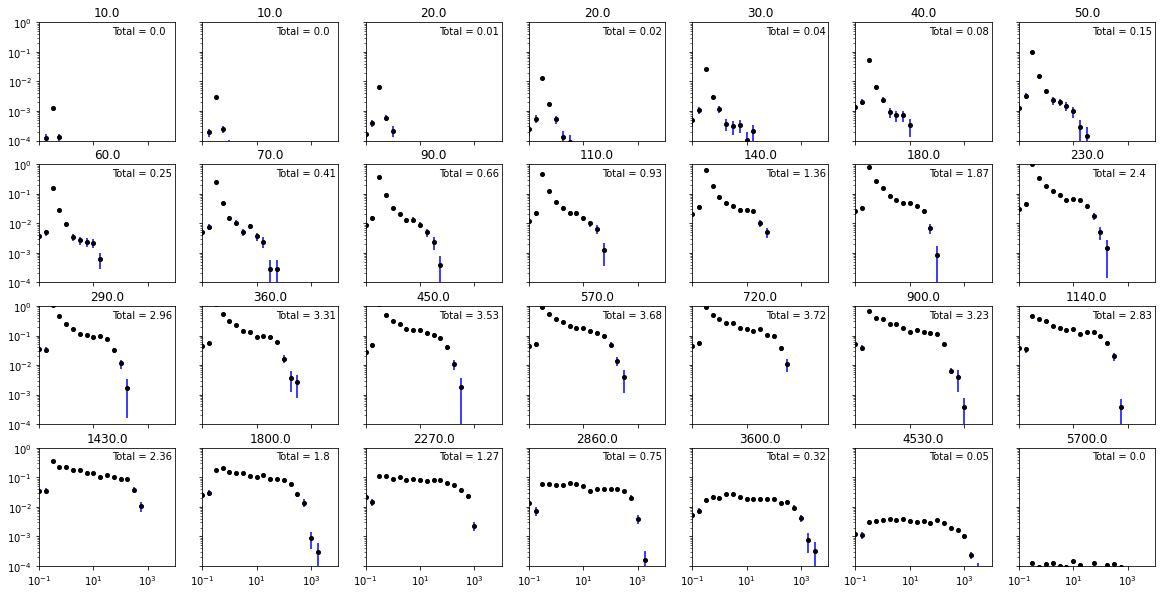

In [21]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_neutrino_data])))
data2 = binSignal(muon_neutrino_data, bins=np.logspace(-2,4,25), weighted=True)

scale = 5
fig, axs = plt.subplots(4,7, sharex=True, sharey=True, figsize=(20,10))
axs = [axs[i,j] for i in range(4) for j in range(7)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data2, primaryEnergies = [primEnergy], scale = scale)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**4])
    plt.ylim([10**-4, 10**0]);
    plt.title(str(np.round(primEnergy,-1)))
    plt.text(5*10**1, 4*10**-1,'Total = ' + str(np.round(counts,2)))

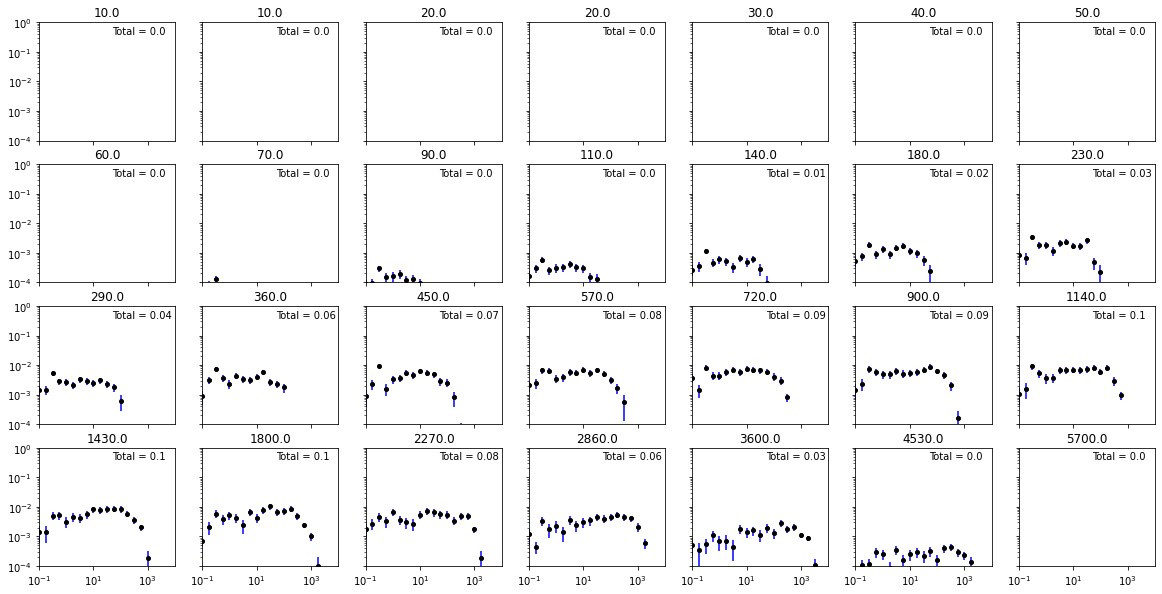

In [22]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in elec_neutrino_data])))
data3 = binSignal(elec_neutrino_data, bins=np.logspace(-2,4,25), weighted=True)

fig, axs = plt.subplots(4,7, sharex=True, sharey=True, figsize=(20,10))
axs = [axs[i,j] for i in range(4) for j in range(7)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data3, primaryEnergies = [primEnergy])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**4])
    plt.ylim([10**-4, 10**0]);
    plt.title(str(np.round(primEnergy,-1)))
    plt.text(5*10**1, 4*10**-1,'Total = ' + str(np.round(counts,2)))

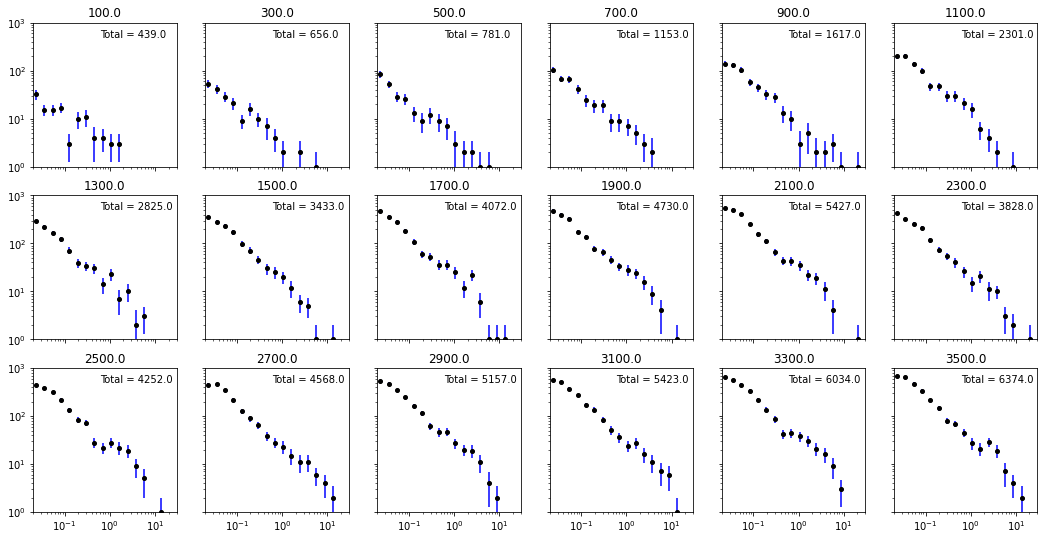

In [23]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_data])))
data1_unweighted = binSignal(muon_data, bins=np.logspace(-2,1.5,20), weighted=False)

fig, axs = plt.subplots(3,6, sharex=True, sharey=True, figsize=(18,9))
axs = [axs[i,j] for i in range(3) for j in range(6)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data1_unweighted, primaryEnergies = [primEnergy])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([2*10**-2, 3*10**1])
    plt.ylim([10**0, 1000]);
    plt.title(str(np.round(primEnergy,-2)))
    plt.text(6*10**-1, 5*10**2,'Total = ' + str(np.round(counts)))

In [159]:
from sklearn.linear_model import LinearRegression


def modelData(binData, minEnergy=0):
    bins = binData['bins']
    energyMask = bins > minEnergy
    primaryEnergies = [e for e in binData.keys() if isinstance(e,float)]

    models = {}
    x1 = np.reshape(np.log10(bins),(np.size(bins),1))[energyMask]
    x2 = np.reshape(bins,(np.size(bins),1))[energyMask]
    X = np.append(-x1,-x2,1)
    for en in primaryEnergies:
        y = binData[en][0][energyMask]
        err = binData[en][1][energyMask]
        
        # zeros are problematic in division and logs
        mask = y > 0
        err = 1/np.log(10) * err[mask]/y[mask]
        y = np.reshape(np.log10(y[mask]),(np.sum(mask),1))
        weights = 1/err

        # Fit the weighted linear model
        model = LinearRegression(positive=True).fit(X[mask,:], y, weights)
        y_pred = model.predict(X[mask,:])
        
        # Compute covariance matrix
        r2 = np.dot((y-y_pred).transpose(),np.dot(np.diag(weights),(y-y_pred)))
        N, p = np.shape(X[mask,:])
        p = p + 1
        X_with_const = np.zeros((N,p))
        X_with_const[:,0] = 1
        X_with_const[:,1:] = X[mask,:]
        covMat = r2 / (N-p) * np.linalg.inv(np.dot(X_with_const.transpose(),np.dot(np.diag(weights),X_with_const)))
        
        models[en] = (model, covMat)
    
    return models

def predModel(model, covMat, energies):
        
    coefs = model.coef_
    intercept = model.intercept_

    a = coefs[0][0]
    b = coefs[0][1] * np.log(10)
    C = 10 ** intercept[0]

    scaling = np.diag([1/(np.log(10) * C), 1, 1/np.log(10)])
    covMat = np.dot(scaling, np.dot(covMat, scaling))

    y_mean = C * energies ** -a * np.exp(-b*energies)
    dydC = y_mean / C
    dyda = - np.log(energies) * y_mean
    dydb = - y_mean / energies
    dy = np.array([dydC, dyda, dydb])

    y_err = np.sqrt(np.einsum('ji,jk,ki->i', dy, covMat, dy))
    
    return y_mean, y_err

def plotModels(binData, models, weights = None):
    primaryEnergies = models.keys()
    x1 = np.linspace(-3,2,1000)
    energies = 10 ** x1

    fig, axs = plt.subplots(3,6, sharex=True, sharey=True, figsize=(18,9))
    axs = [axs[i,j] for i in range(3) for j in range(6)]
    for (primEnergy, ax) in zip(primaryEnergies,axs):
        if weights is None:
            weight = 1
        else:
            weight = weights[primEnergy]
            
        plt.sca(ax)
        counts = plotCounts(binData, primaryEnergies = [primEnergy])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([10**-2, 10**2]);
        plt.xticks([10**-2, 10**-1, 10**0, 10**1, 10**2])
        plt.ylim([10**-1, 10**3]);
        plt.title(str(np.round(primEnergy,-2)))
        plt.text(6*10**-1, 5*10**2,'Total = ' + str(np.round(counts)))
        
        model  = models[primEnergy][0]
        covMat = models[primEnergy][1]
        
        y_mean, y_err = predModel(model, covMat, energies)
        
        plt.plot(energies, y_mean, '--r')
        plt.fill_between(energies, y_mean-y_err, y_mean+y_err, color='r', alpha=0.2)
    return fig

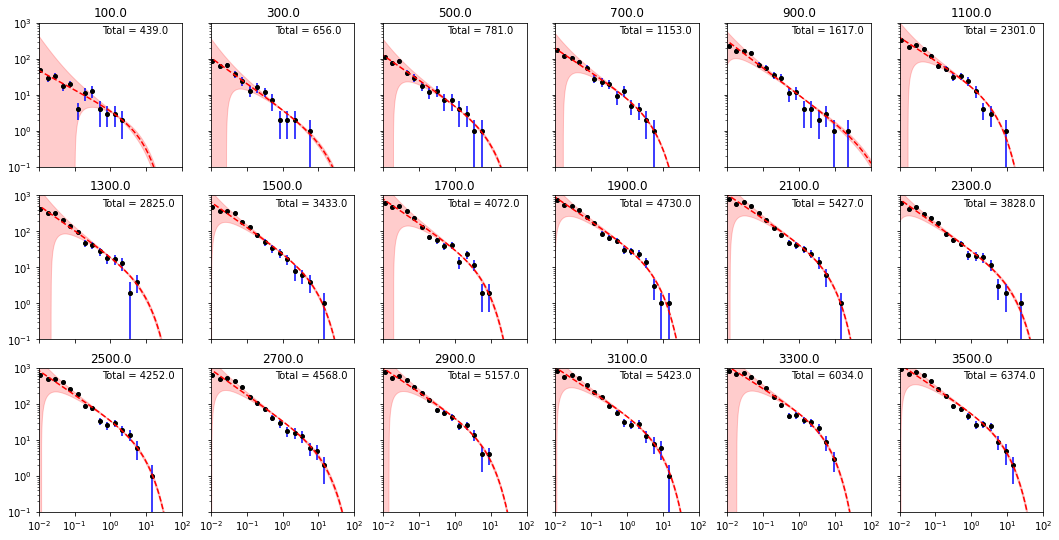

In [317]:
unweighted_muons = binSignal(muon_data, bins=np.logspace(-3,2,25), weighted=False)
unweighted_models = modelData(unweighted_muons, minEnergy=10**-2)
plotModels(unweighted_muons,unweighted_models);

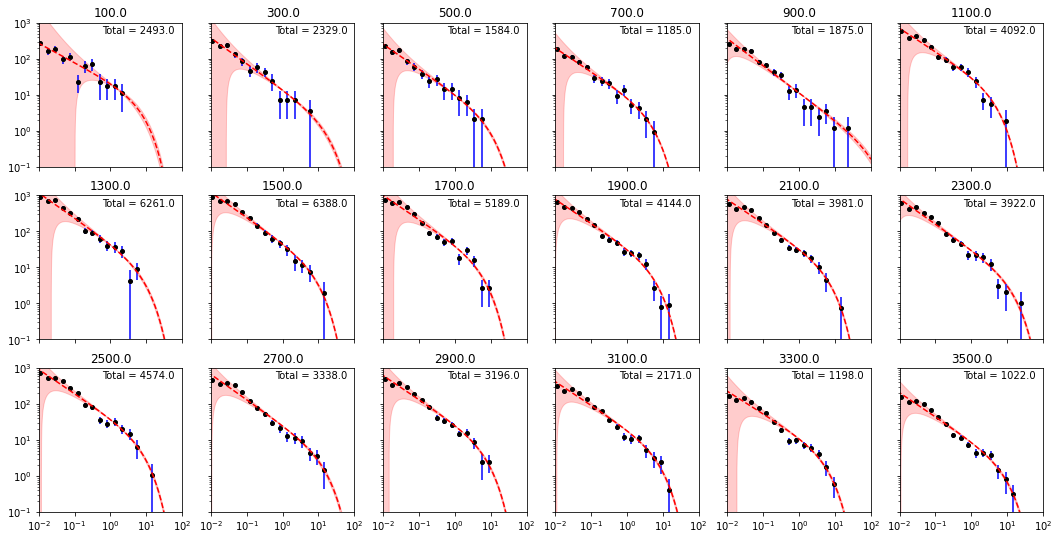

In [319]:
weighted_muons = binSignal(muon_data, bins=np.logspace(-3,2,25))
weighted_models = modelData(weighted_muons, minEnergy=10**-2)
fig = plotModels(weighted_muons, weighted_models);
fig.savefig('GeneratedPlots/background_models.pdf')

In [166]:
from scipy.integrate import quad

def integrand1(x, a, b):
    return x ** -a * np.exp(-b*x)

def integrand2(x, a, b):
    return np.log(x) * integrand1(x, a, b)

def integrateModel(models, E_min = 1):
    count = 0
    uncer = 0
    
    for (model, covMat) in models.values():
        coefs = model.coef_
        intercept = model.intercept_
        
        a = coefs[0][0]
        b = coefs[0][1] * np.log(10)
        C = 10 ** intercept[0]
        
        scaling = np.diag([1/(np.log(10) * C), 1, 1/np.log(10)])
        covMat = np.dot(scaling, np.dot(covMat, scaling))
                
        I = - C * np.diff(quad(integrand1, E_min, np.inf, args=(a,b)))
        dIda = - C * np.diff(quad(integrand2, E_min, np.inf, args=(a,b)))
        dIdb = - C * np.diff(quad(integrand1, E_min, np.inf, args=(a-1,b)))
        dIdC = I / C
        
        dI = np.array([dIdC, dIda, dIdb])
        
        cov_I2 = np.dot(dI.transpose(),np.dot(covMat,dI))[0]
        
        count += I
        uncer += np.sqrt(cov_I2)
    return count[0], uncer[0]


for E_min in [1, 5, 10, 15, 20, 25, 30]:
    print(integrateModel(weighted_models, E_min = E_min))

(1254.7479112492497, 106.11207498982706)
(511.36572825899015, 81.54577997899594)
(247.03328862501772, 59.022635721784255)
(142.80971227744425, 44.89454286089662)
(93.49932465543554, 35.87217934405668)
(67.36313595159116, 30.01185312005149)
(52.19647849669522, 26.111767039314863)


In [255]:
from scipy.integrate import simpson

def integrateModel_num(models, E_min = 1, E_max = 1000, n=100000):
    
    value = 0
    error = 0
    
    energies = np.linspace(E_min, E_max, n)
    
    for (model, covMat) in models.values():
        y_mean, y_err = predModel(model, covMat, energies)
        
        value += simpson(y_mean, energies)
        error += simpson(y_err, energies)
    return value, error

def integrateModel2_num(model, covMat, E_min = 1, E_max = 1000, n=100000):
     
    energies = np.linspace(E_min, E_max, n)
    y_mean, y_err = predSummedModel(model, covMat, energies)

    value = simpson(y_mean, energies)
    error = simpson(y_err, energies)
    return value, error

for E_min in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    print(integrateModel(weighted_models, E_min = E_min))
    print(integrateModel_num(weighted_models, E_min = E_min))

(1254.7479112492497, 106.11207498982706)
(1254.7448934582562, 101.04703879683332)
(511.36572825899015, 81.54577997899594)
(511.36268674590036, 69.46289791284286)
(247.03328862501772, 59.022635721784255)
(247.0302462118932, 41.21321275710995)
(142.80971227744425, 44.89454286089662)
(142.80667032239467, 26.764116414288328)
(93.49932465543554, 35.87217934405668)
(93.4962826303498, 18.98042948161137)
(67.36313595159116, 30.01185312005149)
(67.36009365417253, 14.50319696655408)
(52.19647849669522, 26.111767039314863)
(52.19343664898369, 11.75051189667058)
(42.670077932084176, 23.42926121781943)
(42.66703613579274, 9.943304580626997)
(36.248509406451845, 21.50905171684329)
(36.24546782580161, 8.68039736928823)
(31.64263643493738, 20.072826274453142)
(31.639594053876355, 7.746321492556997)
(28.159189738106388, 18.949807979593846)
(28.156147152118372, 7.020589434514467)


In [177]:
def printCounts(minCal, scale):
    
    muons_sim     = countSignalEvents(muon_data, minCal = minCal)
    muonCount_sim = muons_sim[0]*scale
    muonErr_sim   = muons_sim[1]*scale
    muons_model     = integrateModel_num(weighted_models, E_min = minCal) * scale
    muonCount_model = muons_model[0]*scale
    muonErr_model   = muons_model[1]*scale
    numus     = countSignalEvents(muon_neutrino_data, minCal = minCal)
    numuCount = numus[0]*scale
    numuErr   = numus[1]*scale
    nues      = countSignalEvents(elec_neutrino_data, minCal = minCal)*scale
    nueCount  = nues[0]*scale
    nueErr    = nues[1]*scale
    print(f'For {scale} fb^-1 and a calorimeter cut = {minCal} GeV:',
          '\n\tMuon: (Sim)\t\t', np.round(muonCount_sim,2), '+/-', np.round(muonErr_sim,2),
          '\n\tMuon: (Model)\t\t', np.round(muonCount_model,2), '+/-', np.round(muonErr_model,2),
          '\n\tMuon Neutrino: \t\t', np.round(numuCount,2), '+/-', np.round(numuErr,2),
          '\n\tElectron Neutrino: \t', np.round(nueCount,2), '+/-', np.round(nueErr,2))
    
LHCrun = 5 # in fb^-1
for minCal in [10**-1, 1, 5, 10, 15, 20, 25, 30, 35]:
    printCounts(minCal = minCal, scale = LHCrun)

For 5 fb^-1 and a calorimeter cut = 0.1 GeV: 
	Muon: (Sim)		 23129.37 +/- 2077.48 
	Muon: (Model)		 10001.13 +/- 872.42 
	Muon Neutrino: 		 32.79 +/- 0.88 
	Electron Neutrino: 	 3.92 +/- 0.3
For 5 fb^-1 and a calorimeter cut = 1 GeV: 
	Muon: (Sim)		 3060.22 +/- 685.48 
	Muon: (Model)		 6273.72 +/- 505.24 
	Muon Neutrino: 		 12.89 +/- 0.54 
	Electron Neutrino: 	 2.92 +/- 0.26
For 5 fb^-1 and a calorimeter cut = 5 GeV: 
	Muon: (Sim)		 175.61 +/- 107.82 
	Muon: (Model)		 2556.81 +/- 347.31 
	Muon Neutrino: 		 6.97 +/- 0.39 
	Electron Neutrino: 	 2.17 +/- 0.22
For 5 fb^-1 and a calorimeter cut = 10 GeV: 
	Muon: (Sim)		 27.19 +/- 27.19 
	Muon: (Model)		 1235.15 +/- 206.07 
	Muon Neutrino: 		 5.08 +/- 0.33 
	Electron Neutrino: 	 1.78 +/- 0.2
For 5 fb^-1 and a calorimeter cut = 15 GeV: 
	Muon: (Sim)		 11.05 +/- 11.05 
	Muon: (Model)		 714.03 +/- 133.82 
	Muon Neutrino: 		 4.07 +/- 0.29 
	Electron Neutrino: 	 1.52 +/- 0.18
For 5 fb^-1 and a calorimeter cut = 20 GeV: 
	Muon: (Sim)		 0 +/- 0 
	M

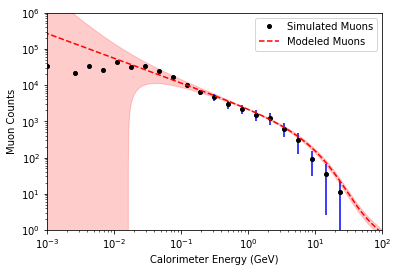

In [314]:
def plotModelsSummed(binData, models, scale = 1):
    primaryEnergies = models.keys()
    x = np.linspace(-4,3,1000)
    energies = 10 ** x
    
    fig = plt.figure()
    
    plotCountsSummed(binData, scale = scale)
    plt.xlabel('Calorimeter Energy (GeV)')
    plt.ylabel('Muon Counts')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-3, 10**2])
    plt.ylim([10**0, 10**6]);
    
    model_mean = 0
    model_err  = 0
    for (model, covMat) in models.values():
        y_mean, y_err = predModel(model, covMat, energies)
        
        model_mean += y_mean
        model_err  += y_err
    
    model_mean *= scale
    model_err *= scale
    plt.plot(energies, model_mean, '--r')
    plt.fill_between(energies, model_mean - model_err, model_mean + model_err, color='r', alpha=0.2)

    plt.legend(['Simulated Muons', 'Modeled Muons'])
    return fig

fig = plotModelsSummed(weighted_muons, weighted_models, scale = 5);
fig.savefig('GeneratedPlots/background_sim_vs_model.pdf')

In [279]:
def calcCuts(cuts, muon_data, muon_neutrino_data, elec_neutrino_data, muon_models):
    muonCount_sim = []
    muonError_sim = []
    numuCount_sim = []
    numuError_sim = []
    nueCount_sim = []
    nueError_sim = []
    muonCount_model = []
    muonError_model = []
    for cut in enCuts:
        muons_sim   = countSignalEvents(muon_data, minCal = cut)
        numus_sim   = countSignalEvents(muon_neutrino_data, minCal = cut)
        nues_sim    = countSignalEvents(elec_neutrino_data, minCal = cut)
        muons_model = integrateModel_num(muon_models, E_min = cut)
        
        muonCount_sim.append(muons_sim[0])
        muonError_sim.append(muons_sim[1])
        numuCount_sim.append(numus_sim[0])
        numuError_sim.append(numus_sim[1])
        nueCount_sim.append(nues_sim[0])
        nueError_sim.append(nues_sim[1])
        muonCount_model.append(muons_model[0])
        muonError_model.append(muons_model[1])
    return [(muonCount_sim, muonError_sim),
           (numuCount_sim, numuError_sim),
           (nueCount_sim, nueError_sim),
           (muonCount_model, muonError_model)]

enCuts = np.logspace(-1,2,30)
cuts = calcCuts(enCuts, muon_data, muon_neutrino_data, elec_neutrino_data, weighted_models)

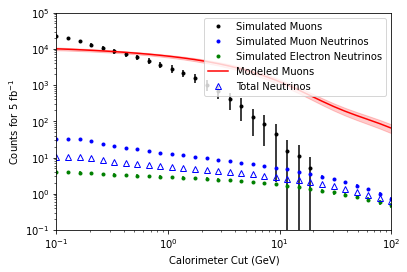

In [280]:
def plotCuts(enCuts, cuts, scale = 1):
    
    fig = plt.figure()
    for ((count, error), color) in zip(cuts,'kbgr'):
        count = np.array(count) * scale
        error = np.array(error) * scale
        if color == 'r':
            plt.plot(enCuts, count, color)
            plt.fill_between(enCuts, count-error, count+error, color=color, alpha=0.2)
        else:
            plt.plot(enCuts, count, 'o' + color, markersize=3)
            plt.errorbar(enCuts, count, error, fmt=' ', color=color)
    neutrinoCounts = np.array(cuts[1][0]) + np.array(cuts[2][0]) * scale
    neutrinoErrors = np.array(cuts[1][1]) + np.array(cuts[2][1]) * scale
    plt.plot(enCuts, neutrinoCounts, '^b', markersize=6, fillstyle='none')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1,10**2])
    plt.ylim([10**-1,10**5])
    plt.xlabel('Calorimeter Cut (GeV)')
    plt.ylabel('Counts for 5 fb$^{-1}$')
    plt.legend(['Simulated Muons', 'Simulated Muon Neutrinos', 'Simulated Electron Neutrinos', 'Modeled Muons', 'Total Neutrinos'])
    return fig

fig = plotCuts(enCuts, cuts, scale = 5);
fig.savefig('GeneratedPlots/expectedCounts_calorimeterCuts_2.pdf')

In [309]:
def cutData(data, calCuts):
    
    counts = []
    errors = []
    for calCut in calCuts:
        count, error = countSignalEvents(data, minCal = calCut)
        counts.append(count)
        errors.append(error)
    counts = np.array(counts)
    errors = np.array(errors)
    
    
    return {'calCuts': calCuts, 'counts': counts, 'errors': errors}

def modelSummedEvents(data):

    calCuts = data['calCuts']
    counts  = data['counts']
    errors  = data['errors']
    
    mask = counts > 0
    y = np.log(counts[mask])
    y_err = errors[mask] / y
    weights = 1 / y_err
    
    X = np.append(-np.log(calCuts[mask, np.newaxis]), -calCuts[mask, np.newaxis],1)
    
    # Fit the weighted linear model
    model = LinearRegression(positive=True).fit(X, y, weights)
    y_pred = model.predict(X)
    
    # Compute covariance matrix
    r2 = np.dot((y-y_pred).transpose(),np.dot(np.diag(weights),(y-y_pred)))
    N, p = np.shape(X)
    p = p + 1
    X_with_const = np.zeros((N,p))
    X_with_const[:,0] = 1
    X_with_const[:,1:] = X
    covMat = r2 / (N-p) * np.linalg.inv(np.dot(X_with_const.transpose(),np.dot(np.diag(weights),X_with_const)))

    return model, covMat

def predSummedModel(model, covMat, x):
        
    coefs = model.coef_
    intercept = model.intercept_

    b0 = intercept
    b1 = coefs[0]
    b2 = coefs[1]

    y_mean = np.exp(b0) * x ** -b1 * np.exp(-b2*x)
    dy0 = y_mean
    dy1 = - np.log(x) * y_mean
    dy2 = - y_mean / x
    dy = np.array([dy0, dy1, dy2])
    
    y_err = np.sqrt(np.einsum('ji,jk,ki->i', dy, covMat, dy))
    
    return y_mean, y_err

def plotCutData(data, scale = 1):
    
    energies = data['calCuts']
    counts   = data['counts'] * scale
    errors   = data['errors'] * scale
    
    plt.plot(energies, counts, 'ko', markersize=3)
    plt.errorbar(energies, counts, errors, fmt=' ', color='b')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**2])
    plt.ylim([10**-1, 10**5])

def plotSummedModel(energies, model, covMat, scale = 1):
    
    y_mean, y_err = predSummedModel(model, covMat, energies)
    y_mean = y_mean * scale
    y_err  = y_err  * scale
    plt.plot(energies, y_mean, 'r--')
    y_low = y_mean - y_err
    y_high = y_mean + y_err
    plt.fill_between(energies, y_low, y_high, color='r', alpha=0.2)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**2])
    plt.ylim([10**-1, 10**5])

In [238]:
%%time
cut_muon_data = cutData(muon_data, calCuts = np.logspace(-1,2,30))

CPU times: user 13 s, sys: 0 ns, total: 13 s
Wall time: 13.1 s


CPU times: user 30.8 ms, sys: 23.9 ms, total: 54.7 ms
Wall time: 19.2 ms


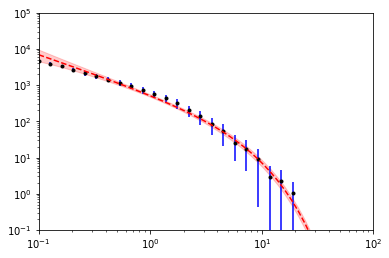

In [310]:
%%time
model, covMat = modelSummedEvents(cut_muon_data)
plotCutData(cut_muon_data)
plotSummedModel(np.logspace(-1,2), model, covMat)

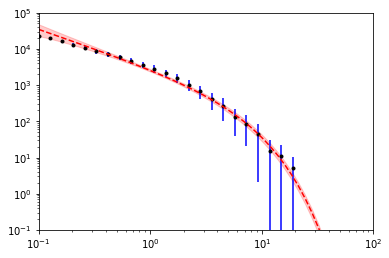

In [311]:
plotCutData(cut_muon_data, scale = 5)
plotSummedModel(np.logspace(-1,2), model, covMat, scale = 5)

In [308]:
def printCounts2(minCal, scale):
    
    muons_sim     = countSignalEvents(muon_data, minCal = minCal)
    muonCount_sim = muons_sim[0]*scale
    muonErr_sim   = muons_sim[1]*scale
    muons_model     = predSummedModel(model, covMat, np.array([minCal]))
    muonCount_model = muons_model[0][0]*scale
    muonErr_model   = muons_model[1][0]*scale
    numus     = countSignalEvents(muon_neutrino_data, minCal = minCal)
    numuCount = numus[0]*scale
    numuErr   = numus[1]*scale
    nues      = countSignalEvents(elec_neutrino_data, minCal = minCal)*scale
    nueCount  = nues[0]*scale
    nueErr    = nues[1]*scale
    nuCount = numuCount + nueCount
    nuErr   = numuErr + nueErr
    totalCount_sim = muonCount_sim + nuCount
    totalError_sim = muonErr_sim + nuErr
    totalCount_model = muonCount_model + nuCount
    totalError_model = muonErr_model + nuErr
    portion_sim = nuCount / totalCount_sim
    portion_err_sim = (muonErr_sim) / totalCount_sim
    portion_model = nuCount / totalCount_model
    portion_err_model = (muonErr_model) / totalCount_model
    print(f'For {scale} fb^-1 and a calorimeter cut = {minCal} GeV:',
          '\n\tMuon: (Sim)\t\t', np.round(muonCount_sim,2), '+/-', np.round(muonErr_sim,2),
          '\n\tMuon: (Model)\t\t', np.round(muonCount_model,2), '+/-', np.round(muonErr_model,2),
          '\n\tMuon Neutrino: \t\t', np.round(numuCount,2), '+/-', np.round(numuErr,2),
          '\n\tElectron Neutrino: \t', np.round(nueCount,2), '+/-', np.round(nueErr,2),
          '\n\tExpected Events (Sim):\t\t', np.round(totalCount_sim,2), '+/-', np.round(totalError_sim,2),
          '\n\tPortion of Events (Sim):\t', np.round(portion_sim,2), '+/-', np.round(portion_err_sim,2),
          '\n\tExpected Events (Model):\t', np.round(totalCount_model,2), '+/-', np.round(totalError_model,2),
          '\n\tPortion of Events (Model):\t', np.round(portion_model,2), '+/-', np.round(portion_err_model,2))
    
LHCrun = 5 # in fb^-1
for minCal in [10**-1, 1, 5, 10, 15, 20, 25, 30, 35]:
    printCounts2(minCal = minCal, scale = LHCrun)

For 5 fb^-1 and a calorimeter cut = 0.1 GeV: 
	Muon: (Sim)		 23129.37 +/- 2077.48 
	Muon: (Model)		 34270.64 +/- 12276.82 
	Muon Neutrino: 		 32.79 +/- 0.88 
	Electron Neutrino: 	 3.92 +/- 0.3 
	Expected Events (Sim):		 23166.09 +/- 2078.67 
	Portion of Events (Sim):	 0.0 +/- 0.09 
	Expected Events (Model):	 34307.35 +/- 12278.01 
	Portion of Events (Model):	 0.0 +/- 0.36
For 5 fb^-1 and a calorimeter cut = 1 GeV: 
	Muon: (Sim)		 3060.22 +/- 685.48 
	Muon: (Model)		 2511.09 +/- 198.72 
	Muon Neutrino: 		 12.89 +/- 0.54 
	Electron Neutrino: 	 2.92 +/- 0.26 
	Expected Events (Sim):		 3076.03 +/- 686.29 
	Portion of Events (Sim):	 0.01 +/- 0.22 
	Expected Events (Model):	 2526.9 +/- 199.52 
	Portion of Events (Model):	 0.01 +/- 0.08
For 5 fb^-1 and a calorimeter cut = 5 GeV: 
	Muon: (Sim)		 175.61 +/- 107.82 
	Muon: (Model)		 203.76 +/- 31.61 
	Muon Neutrino: 		 6.97 +/- 0.39 
	Electron Neutrino: 	 2.17 +/- 0.22 
	Expected Events (Sim):		 184.75 +/- 108.43 
	Portion of Events (Sim):	 0.05

In [271]:
def calcCuts2(cuts, muon_data, muon_neutrino_data, elec_neutrino_data):
    
    data = {'cuts': cuts,
            'muon_sim'      : {},
            'muon_neutrino' : {},
            'elec_neutrino' : {}}
    for cut in cuts:
        data['muon_sim'][cut]      = countSignalEvents(muon_data, minCal = cut)
        data['muon_neutrino'][cut] = countSignalEvents(muon_neutrino_data, minCal = cut)
        data['elec_neutrino'][cut] = countSignalEvents(elec_neutrino_data, minCal = cut)
    for particle in ['muon_sim', 'muon_neutrino', 'elec_neutrino']:
        counts = np.array([count for (count, error) in data[particle].values()])
        errors = np.array([error for (count, error) in data[particle].values()])
        data[particle]['counts'] = counts
        data[particle]['errors'] = errors

    return data

enCuts = np.logspace(-1,2,30)
cuts = calcCuts2(enCuts, muon_data, muon_neutrino_data, elec_neutrino_data)

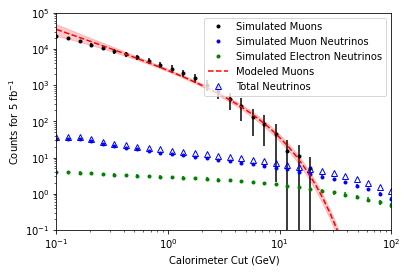

In [277]:
def plotCuts2(data, model, covMat, scale = 1):
    
    energies = data['cuts']
    
    fig = plt.figure()
    for (particle, color) in [('muon_sim', 'k'),
                              ('muon_neutrino', 'b'),
                              ('elec_neutrino', 'g')]:
        
        counts = data[particle]['counts'] * scale
        errors = data[particle]['errors'] * scale
        plt.plot(energies, counts, 'o' + color, markersize=3)
        plt.errorbar(energies, counts, errors, fmt=' ', color=color)
    plotSummedModel(np.logspace(-1,2), model, covMat, scale = scale)
    neutrinoCounts = (data['muon_neutrino']['counts'] + data['elec_neutrino']['counts']) * scale
    neutrinoErrors = (data['muon_neutrino']['errors'] + data['elec_neutrino']['errors']) * scale
    plt.plot(enCuts, neutrinoCounts, '^b', markersize=6, fillstyle='none')
#     plt.errorbar(enCuts, neutrinoCounts, neutrinoErrors, fmt=' ', color='b')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1,10**2])
    plt.ylim([10**-1,10**5])
    plt.xlabel('Calorimeter Cut (GeV)')
    plt.ylabel('Counts for 5 fb$^{-1}$')
    plt.legend(['Simulated Muons', 'Simulated Muon Neutrinos', 'Simulated Electron Neutrinos', 'Modeled Muons', 'Total Neutrinos'])
    return fig

fig = plotCuts2(cuts, model, covMat, scale = 5);
fig.savefig('GeneratedPlots/expectedCounts_calorimeterCuts.pdf')

# Attempt to Use Cluster Learning Algorithm to Classify Primary Particles

Begin by organizing the data

# TODO:
Turn tracker data into macro-observables (numhits, centrality, etc.)

In [37]:
# For sparse arrays to feed to sklearn
import scipy.sparse as sparse

def coordsToIndex(x,y):
    x = x + 12
    y = y + 12
    return x + ((y-1) * 25)

def eventToSparse(event):
    n_col = 1 + (25*25)*4
    mat = sparse.lil_matrix(np.zeros((1,n_col)))
    mat[0,0] = event['calorimeter']
    for n in [1, 2, 3, 4]:
        hits = event[f'hits{n}']
        for hit in hits:
            ind = coordsToIndex(hit[0],hit[1])
            mat[0,ind + 625*(n-1)] = hit[2]
    return mat

# Need this scintillator pattern to avoid cosmics and remove the first pair of scintillators
signal  = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
entries = np.array([n for n in range(10)])

muon_matches = [event for event in muon_data if (event['scintillator'][entries] == signal).all()]
numu_matches = [event for event in muon_neutrino_data if (event['scintillator'][entries] == signal).all()]
nue_matches = [event for event in elec_neutrino_data if (event['scintillator'][entries] == signal).all()]

In [21]:
print(len(muon_matches),len(numu_matches),len(nue_matches))

52164 65016 10091


In [38]:
n_col = 1 + (25*25)*4
Xmu_train = sparse.lil_matrix(np.zeros((0, n_col)))
muon_sample = random.sample(muon_matches,1250)
muon_train = muon_sample[:1000]
muon_test  = muon_sample[1000:]
for event in muon_train:
    mat = eventToSparse(event)
    Xmu_train = sparse.vstack((Xmu_train,mat))

In [39]:
n_col = 1 + (25*25)*4
Xnumu_train = sparse.lil_matrix(np.zeros((0, n_col)))
numu_sample = random.sample(numu_matches,1250)
numu_train = numu_sample[:1000]
numu_test  = numu_sample[1000:]
for event in numu_train:
    mat = eventToSparse(event)
    Xnumu_train = sparse.vstack((Xnumu_train,mat))

In [40]:
n_col = 1 + (25*25)*4
Xnue_train = sparse.lil_matrix(np.zeros((0, n_col)))
nue_sample = random.sample(nue_matches,1250)
nue_train = nue_sample[:1000]
nue_test  = nue_sample[1000:]
for event in nue_train:
    mat = eventToSparse(event)
    Xnue_train = sparse.vstack((Xnue_train,mat))

In [41]:
n_col = 1 + (25*25)*4
Xmu_test = sparse.lil_matrix(np.zeros((0, n_col)))
for event in muon_test:
    mat = eventToSparse(event)
    Xmu_test = sparse.vstack((Xmu_test,mat))

In [42]:
n_col = 1 + (25*25)*4
Xnumu_test = sparse.lil_matrix(np.zeros((0, n_col)))
for event in numu_test:
    mat = eventToSparse(event)
    Xnumu_test = sparse.vstack((Xnumu_test,mat))

In [43]:
n_col = 1 + (25*25)*4
Xnue_test = sparse.lil_matrix(np.zeros((0, n_col)))
for event in nue_test:
    mat = eventToSparse(event)
    Xnue_test = sparse.vstack((Xnue_test,mat))

In [44]:
sparse.save_npz('SparseArrays/muon_train_1000.npz',Xmu_train)
sparse.save_npz('SparseArrays/numu_train_1000.npz',Xnumu_train)
sparse.save_npz('SparseArrays/nue_train_1000.npz',Xnue_train)
sparse.save_npz('SparseArrays/muon_test_250.npz',Xmu_test)
sparse.save_npz('SparseArrays/numu_test_250.npz',Xnumu_test)
sparse.save_npz('SparseArrays/nue_test_250.npz',Xnue_test)

In [45]:
from sklearn.neighbors import KNeighborsClassifier

n_col = 1 + (25*25)*4
X_train = sparse.lil_matrix(np.zeros((0, n_col)))
X_train = sparse.vstack((X_train,Xmu_train))
X_train = sparse.vstack((X_train,Xnumu_train))
X_train = sparse.vstack((X_train,Xnue_train))
y_train = np.zeros((3000,))
y_train[1000:2000] = np.ones((1000,))
y_train[2000:] = np.ones((1000,))*2

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [46]:
X_test = sparse.lil_matrix(np.zeros((0, n_col)))
X_test = sparse.vstack((X_test,Xmu_test))
X_test = sparse.vstack((X_test,Xnumu_test))
X_test = sparse.vstack((X_test,Xnue_test))
y_pred = knn.predict(X_test)

In [47]:
y_test = np.zeros((750,))
y_test[250:500] = np.ones((250,))
y_test[500:] = np.ones((250,))*2

print('Number of correct (Muon Neutrinos vs Electron Neutrinos vs Muons):', np.sum(y_pred == y_test))
print('Number of correct (Neutrinos vs Muons):', np.sum((y_pred > 0) == (y_test > 0)))

print('Correct Ratio (Muon Neutrinos vs Electron Neutrinos vs Muons):', np.sum(y_pred == y_test)/np.size(y_pred))
print('Correct Ratio (Neutrinos vs Muons):', np.sum((y_pred > 0) == (y_test > 0))/np.size(y_pred))

Number of correct (Muon Neutrinos vs Electron Neutrinos vs Muons): 421
Number of correct (Neutrinos vs Muons): 556
Correct Ratio (Muon Neutrinos vs Electron Neutrinos vs Muons): 0.5613333333333334
Correct Ratio (Neutrinos vs Muons): 0.7413333333333333


74% Probability seems promising. Note that this is for all possible energy deposits in the calorimeter. Could we improve it by adding a requirement on the calorimeter energy?

In [63]:
mask = (((y_pred > 0) == (y_test > 0)) - 1) < 0
inds = np.where(mask)
wrongs = X_test.tocsr()[inds,0].toarray()

In [68]:
wrongs

array([[1.110e-01],
       [4.600e-02],
       [3.000e-03],
       [7.700e-02],
       [3.817e+00],
       [4.000e-03],
       [5.000e-02],
       [4.300e-02],
       [2.500e-02],
       [1.870e-01],
       [5.000e-03],
       [3.000e-03],
       [7.000e-03],
       [3.000e-03],
       [2.520e-01],
       [6.600e-02],
       [1.500e-02],
       [2.300e-02],
       [2.260e-01],
       [1.000e-03],
       [6.640e-01],
       [2.450e-01],
       [2.770e-01],
       [1.100e-02],
       [1.000e-03],
       [3.200e-02],
       [2.060e-01],
       [5.510e-01],
       [1.000e-03],
       [2.000e-03],
       [4.680e-01],
       [3.570e-01],
       [2.200e-02],
       [4.000e-03],
       [4.490e-01],
       [3.580e-01],
       [2.000e-01],
       [6.770e-01],
       [4.810e-01],
       [2.260e-01],
       [3.690e-01],
       [2.050e-01],
       [2.000e-03],
       [1.156e+00],
       [0.000e+00],
       [4.540e-01],
       [5.310e-01],
       [4.700e-02],
       [1.070e-01],
       [5.320e-01],
